In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import seaborn as sns
from ipywidgets import interact

%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

In [2]:
class lifetable:
 
    def __init__(self):
        '''
        set up the lifetable with a big numpy array
        '''
        self.data = np.zeros((2014-1816+1, 111))
        self.years = np.zeros(2014-1816+1)
        
        self.data.fill(np.nan)
        self.years.fill(np.nan)
        
        self.minyear = 9999
        self.maxyear = -9999
        self.colour = "dodgerblue"
        self.ignorezero = False
        
    def add_value(self, year, age, number):
        '''
        Set value in the lifetable
        '''
        self.data[year-1816,age] = number       
        self.years[year-1816] = year
        if year > self.maxyear: self.maxyear = year
        if year < self.minyear: self.minyear = year

    def switchcolour(self):
        '''
        Alternate between colours for plotting etc.
        '''
        if self.colour == "dodgerblue":
            self.colour = "red"
        else:
            self.colour = "dodgerblue"
    
    def plot_data(self, age, ystart=1816):
        '''
        Plot the survivors per 100k for a particular age from ystart to 2014
        '''
        y1 = ystart
        if y1 < self.minyear: y1 = self.minyear
        y2 = 2014
        if y2 > self.maxyear: y2 = self.maxyear
        
        x = self.years[y1-1816:y2-1816+1]
        y = self.data[y1-1816:y2-1816+1, age]
        plt.plot(x, y, color=self.colour)
        plt.text(y2+1,lt.data[y2-1816,age], str(age), color=self.colour)
        
        return       
    
    def calc_trend(self, age, ystart, yend):
        '''
        Calculate trend for survivors per 100k
        '''
        x  = self.years[ystart-1816:yend-1816+1]
        y1 = self.data[ystart-1816:yend-1816+1, age]
      
        if self.ignorezero:
            index0 = np.nonzero(y1==0)
            index2 = np.nonzero(y1)
            y = y1*1
            y[index2] = np.log10(y1[index2])
            y[index0] = 0
            slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
            
            return slope, intercept
        
        if min(y1) <= 0:
            return np.nan, np.nan
        
        y = np.log10(y1)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        
        return slope, intercept
    
    def plot_log_trend(self, age, ystart, yend):
        
        y1 = ystart
        if y1 < self.minyear: y1 = self.minyear
        y2 = yend
        if y2 > self.maxyear: y2 = self.maxyear
        
        slope, intercept = self.calc_trend(age, y1, y2)
        if slope != np.nan:
            x  = self.years[y1-1816:y2-1816+1]
            plt.plot(x, x*slope+intercept, color=self.colour)
    
        return
    
    def plot_log_data(self, age, ystart=1816):
        
        y1 = ystart
        if y1 < self.minyear: y1 = self.minyear
        y2 = 2014
        if y2 > self.maxyear: y2 = self.maxyear
        
        x  = self.years[y1-1816:y2-1816+1]
        y1 = self.data[y1-1816:y2-1816+1,age]
       
        y = y1*1
        
        for i, val in enumerate(y1):
            if val > 0:
                y[i] = np.log10(val)
            else:
                y[i] = np.nan
    
        plt.plot(x, y, color=self.colour)  
        plt.text(self.maxyear+1,
                 np.log10(self.data[self.maxyear-1816,age]),
                 str(age),
                 color=self.colour)
        
        return
    
    def get_gradient_as_function_of_age(self, ystart, yend):
        slopes = []
        for age in range(0,111):
            y1 = ystart
            if y1 < self.minyear: y1 = self.minyear
            slope, intercept = self.calc_trend(age, y1, yend)
            slopes.append(slope)
        return slopes

    def get_fig1d(self):
        max_by_year = []

        range0 = 1916
        if range0 < self.minyear: range0 = self.minyear + 2
        range1 = 2014
        if range1 > self.maxyear: range1 = self.maxyear

        for yend in range(range0,range1+1):
            slopes = self.get_gradient_as_function_of_age(yend-99, yend)
            max_value = max(slopes)
            max_index = slopes.index(max_value)
            max_by_year.append(max_index)    

        return range(range0,range1+1),max_by_year

    
def read_lifetable(infile):

    f = open(infile,'r')
    f.readline()
    f.readline()
    f.readline()

    lt = lifetable()
    
    for line in f:
        year = int(line[2:6])
        age = int(line[15:18])
        number = float(line[47:53])
        
        lt.add_value(year, age, number)
   
    return lt

# The good news about death

In the a paper entitled "[Evidence for a limit to human lifespan](http://www.nature.com/nature/journal/v538/n7624/full/nature19793.html)", the authors argue that the results they present "_strongly suggest that the maximum lifespan of humans is fixed and subject to natural constraints_". This is a rather provocative statement and one which rests, in so far as it rests on this paper, on some poor analysis choices. It might be that there are other analyses which support this conclusion, but the question is, what evidence does this paper provide _on its own terms_? And that is what I'm going to try and take a look at.

In the paper, data from two different sources are analysed. The first source is the [Human Mortality Database](http://mortality.org/ "Title") which has information on mortality and longevity gathered from a number of countries. The second is the [International Database on Longevity](http://www.supercentenarians.org/) which contains information on the ages at death of "supercentenarians". Supercentenarians are those who survive past their 110th birthday.

I cannot provide the data from these sources along with this notebook because the data is provided on the understanding that it will not be passed along. However, it is quick and simple to register and get the data. It took me a matter of a few minutes.

I'm going to look at the HMD data from France first as this was the data set used in Figure 1 of the paper, and I'll be  focusing initially on data on female mortality. The statistic we will be looking at initially is "survivors per 100,000 people at age X" from [http://www.mortality.org/hmd/FRATNP/STATS/fltper_1x1.txt](http://www.mortality.org/hmd/FRATNP/STATS/fltper_1x1.txt) which is the 1x1 Lifetable for females.


In [3]:
ystart = 1975
lt = read_lifetable('fltper_1x1.txt')

col = "dodgerblue"
slopes = []

The plot below shows survivors per 100,000 people at age X from 1816 to 2014 when the data set ends. There are big drops in survival around the First and Second World War. The drop in survival around the First World War was deepened by the Spanish flu pandemic. There is huge difference in survival between ages. The vertical scale on each of the diagrams is different. At an age of 110, the series maxes out at around 20 survivors per 100,000, for vastly less advanced ages, like 30, it typically maxes out close to 100,000 because people rarely die young.

There's one weird thing in the data. There is a kind of minimum in survivors/100,000k in the late nineteenth century at ages around 92 and above. The first half of the 1800s was apparently a relatively good time to be a centenarian, at least compared to the second half.

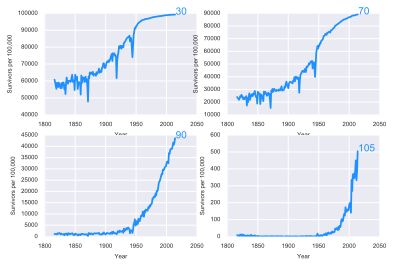

In [4]:
def fourup_age_plot(age,pos):
    ax = plt.subplot(pos, xlabel='Year', ylabel='Survivors per 100,000')
    lt.plot_data(age)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)
        
        
fourup_age_plot(30,221)
fourup_age_plot(70,222)
fourup_age_plot(90,223)
fourup_age_plot(105,224)

plt.show()

Because of the great variation in survival rates with age and time, it is not easy to compare one age with another quite different age, or one time period with a much earlier one, so, as the authors did, we're going to take logarithms of the data to compress everything into a more manageable space. Taking logarithms also has the effect of changing an exponential increase with time into something more linear, though not perfectly linear.

One thing to note with the logarithm is that the logarithm of zero is minus infinity. The data in the file are whole numbers so the fewest survivors per 100,000 you can have is one. For more advanced ages, there are fewer than 1 survivors per 100,000 people, so few that either zero is a better approximation of the number or there were no survivors at that age. Consequently, when I take the logarithms of the data there are some infinities. I don't show the infinities on the plot. Instead, there's a gap in the data trace where the infinities should be and I don't compute or show the linear fit for those ages.

I don't know how exactly the fits to the data were performed in the paper. The following bits and bobs are what I'm basing this attempted replication on. Figure 1b has a log scale on its y-axis and the coloured lines are straight which suggests linear fits to logged data. In the caption for Figure 1c, it says "_plotting the rate of change (coefficients resulting from regression of log-transformed data)_". In extended data figure 4 (which appears in the online version) the caption says "_the rate of change is the slope of the line calculated by an exponential regression, that is, b in the equation y = ax + b, where x is age and y is the logarithm of the number of survivors per 100,000._" Taking this last statement literally causes problems around the use of zeroes, that I'll talk about more in a bit.

The linear fits aren't really a great description of the data, they don't capture the long term change in the data, except in an approximate sense. Around the age of 92, you can see the straight line doesn't come close to capturing, the broad minimum in the late 19th century, nor the gentle flattening off during the late 20th century.

The above-mentioned weirdness in the data is more obvious after logarithms are taken. From around the age of 92 upward, it looks like survivors/100k decreased at first and then increased.

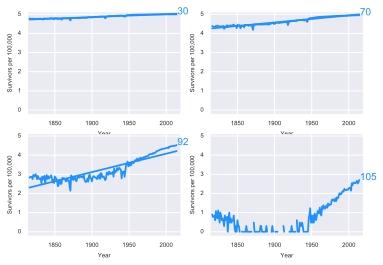

In [5]:
def fourup_log_age_plot(age,pos):
    ax = plt.subplot(pos, xlabel='Year', ylabel='Survivors per 100,000')
    lt.plot_log_data(age, 1816)
    lt.plot_log_trend(age, 1816, 2014)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)
    plt.axis((lt.minyear-2,lt.maxyear+5,-0.2,5.1))

fourup_log_age_plot(30,221)
fourup_log_age_plot(70,222)
fourup_log_age_plot(92,223)
fourup_log_age_plot(105,224)

plt.show()

In the paper,the second panel in the first figure (Figure 1b) shows the linear fits stacked up one on top of the other with each one running from 1900 to the present. It's not clear how the linear fits were computed for those ages where there were zero survivors per 100,000 in some years. There are, of course, various ways that one could deal with this - ignore those years, assign a value to them, etc - but in this firt plot, I've simply omitted the linear fits for those ages where we have some years with zeroes. The plot below shows the logarithms of the numbers of survivors per 100,000 people at age X (for all Xs 70 and above) from 1900 to 2014. Colours alternate so it's easier to work out which label matches which line.

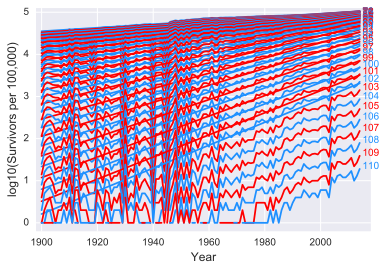

In [6]:
def plot_log_data(ystart=1900, showdata=True):
    lt.colour = "dodgerblue"
    for age in range(70,111):
        if showdata: lt.plot_log_data(age, ystart)
        lt.plot_log_trend(age, ystart, 2014)
        lt.switchcolour()

    plt.xlabel('Year', fontsize=12)
    plt.ylabel('log10(Survivors per 100,000)', fontsize=12)
    plt.axis((ystart-2,2018,-0.2,5.1))
    plt.show()

plot_log_data(1900, True)

The general pattern in the linear fits to the data is that slope of the lines increases with increasing age. If you start the lines off in 1900, then that pattern holds up to the age of 102, the highest age for which we have a non-zero value in every year. The ages for which a linear fit hasn't been calculated, seem by eye, to continue the pattern at least in that part of the record for which there are plentiful data. "By eye" isn't a great way to perform an analysis though but it doesn't hurt to just look at the data. 

However, my attempt doesn't look exactly like the diagram from the paper (Figure 1b). The authors have a line for every age from 70 to 110+. In order to get something that looks like that, I recalculated the above diagram, but everywhere there was a zero in the data, I set the logarithm to zero and not minus infinity. This is probably not what the authors did - they don't say what they did exactly - and it's not correct, but, the resulting shape of the diagram, shown in the next plot, comes out surprisingly close to what they did get.

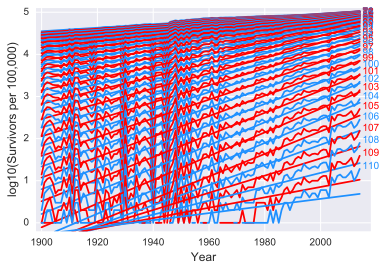

In [7]:
lt.ignorezero = True
plot_log_data(1900, True)

I tried other ways of dealing with the zeroes: setting them to other default values, and just ignoring them. Neither approach looked more like what appears in the paper than just setting the values to zero. Not being able to get an exact match is frustrating though.

It's worth looking at the linear fits and the data to which they were fitted. For some ages, a straight line does a pretty good job of capturing the change in survivors/100k over the 20th Century. However, for other ages - 110 is the most extreme example - the straight line is a terrible description of what actually happened: nothing till 1972 and then a jagged but apparently rapid increase from 1980. Another thing to note is that the lines for more advanced ages cross around 1920. The implication of this is that there were times in the past when survival was systematically better at say 110 than 105 (or linear fits are not a good description of the data).

The authors note that the "_rate of improvement in survival peaks and then declines for very old age levels_". This statement is based on the lines from an age of 103 and up that I recovered by providing dummy values for the zeroes in the data. The flattening out is an artifact of that particular analysis choice. If you make other choices, like computing the linear regressions using only the non-zero values, you get a different shape. 

The next plot (equivalent to Figure 1c in the paper) shows the gradient of the lines for each age. The gradients are calculated from 1900 to 2014. On the left is the version where trends aren't calculated for ages where there are zeroes in the data. On the right is the version where the log of zero is set to zero.

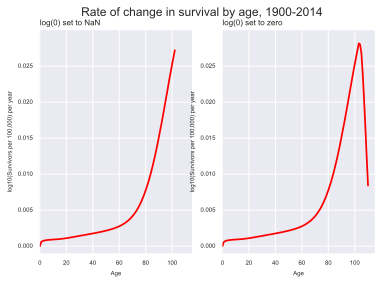

In [8]:
lt.ignorezero = False
slopes2 = lt.get_gradient_as_function_of_age(1900, 2014)
ax = plt.subplot(121, xlabel='Age', ylabel='log10(Survivors per 100,000) per year')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)
plt.plot(range(0,111),slopes2,color=lt.colour)
plt.axis((0,115,-0.001,0.03))
plt.title('log(0) set to NaN', loc='left',fontsize=8)

lt.ignorezero = True
slopes1 = lt.get_gradient_as_function_of_age(1900, 2014)
ax = plt.subplot(122, xlabel='Age', ylabel='log10(Survivors per 100,000) per year')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)
plt.plot(range(0,111),slopes1,color=lt.colour)
plt.axis((0,115,-0.001,0.03))
plt.title('log(0) set to zero', loc='left',fontsize=8)

plt.suptitle('Rate of change in survival by age, 1900-2014',fontsize=12)
plt.show()

    


In the left hand plot above you can see that the rate of change of the logarithm of the number of survivors between 1900 and 2014 increases monotonically. If we allow for a moment that a linear fit is a good description of the data, then the greatest relative gains in survivors/100k are at the highest ages for which we have a continuous series of data.

The right hand plot shows what happens if we include the lines recovered by setting the log of zero to zero. Now, the gradient peaks and falls at ages above 102 as it does in the paper (Figure 1c). The authors note that this "_points towards diminishing gains in reduction of late-life mortality and a possible limit to human lifespan_". As well as the aforementioned problems with how one deals with zeroes and how well a linear fit actually does at modelling these data, there is a more basic problem, which is that there are gains at all ages. A diminishing gain is still a gain and not a limit, which is where the next plot comes in. It shuts the door on the possibility that there is a downturn, but the age with greatest gains in survival has been increasing steadily over time.

The next plot in the paper (Figure 1d) summarised this by showing the age at which the maximum increase occurred for different 100-year period ending in the year shown on the x-axis. Again, I've made versions with the two different choices about how to handle zeroes.

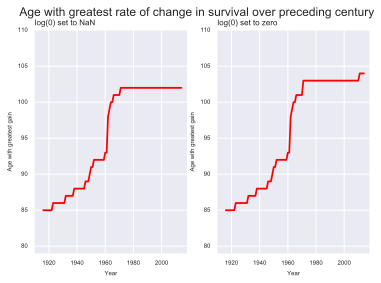

In [9]:
lt.ignorezero = False
x,y = lt.get_fig1d()
ax = plt.subplot(121, xlabel='Year', ylabel='Age with greatest gain')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)
plt.plot(x,y,color=lt.colour)
plt.axis((1910,2018,79,110))
plt.title('log(0) set to NaN', loc='left',fontsize=8)

lt.ignorezero = True
x,y = lt.get_fig1d()
ax = plt.subplot(122, xlabel='Year', ylabel='Age with greatest gain')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)
plt.plot(x,y,color=lt.colour)
plt.axis((1910,2018,79,110))
plt.title('log(0) set to zero', loc='left',fontsize=8)

plt.suptitle('Age with greatest rate of change in survival over preceding century',fontsize=12)
plt.show()

Finally, we have got to the end of the first figure in the paper and most of the features are there. The authors say "_the results indicate that the age with greatest improvement in survival appeared to plateau around 1980_." and they also say, in the caption for Figure 1d that "_the age with most rapid gains in survival over the past 100 years has increased over the century, but its rise has been slowing and it appears to have reached a plateau_".

In the left hand plot above, the plateau simply represents the fact that we maxed out on the curve; 102 is the highest age for which we can calculate a trend through that whole period. It's not a plateau, it's just that there is no higher value to go to. On the right, the plateau runs slightly higher, but the max here is coming from the turnover in Figure 1c, which as we've seen is tied to some unspecified analytic choices.

We can now add in the data for men as well, which are somewhat different but suffer all the same problems. The file is [http://www.mortality.org/hmd/FRATNP/STATS/mltper_1x1.txt](http://www.mortality.org/hmd/FRATNP/STATS/mltper_1x1.txt)

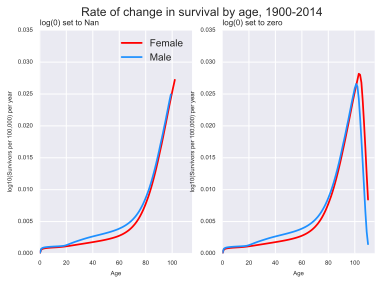

In [10]:
mlt = read_lifetable('mltper_1x1.txt')

mlt.colour = "dodgerblue"
lt.colour = "red"

lt.ignorezero = False
mlt.ignorezero = False
slopesf = lt.get_gradient_as_function_of_age(1900, 2014)
slopesm = mlt.get_gradient_as_function_of_age(1900, 2014)

ax = plt.subplot(121, xlabel='Age', ylabel='log10(Survivors per 100,000) per year')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)
plt.plot(range(0,111),slopesf,color=lt.colour,label='Female')
plt.plot(range(0,111),slopesm,color=mlt.colour,label='Male')
plt.axis((0,115,0.00,0.035))
plt.legend()
plt.title('log(0) set to Nan', loc='left', fontsize=8)

lt.ignorezero = True
mlt.ignorezero = True
slopesf = lt.get_gradient_as_function_of_age(1900, 2014)
slopesm = mlt.get_gradient_as_function_of_age(1900, 2014)

ax = plt.subplot(122, xlabel='Age', ylabel='log10(Survivors per 100,000) per year')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)
plt.plot(range(0,111),slopesf,color=lt.colour,label='Female')
plt.plot(range(0,111),slopesm,color=mlt.colour,label='Male')
plt.axis((0,115,0.00,0.035))
plt.title('log(0) set to zero', loc='left', fontsize=8)


plt.suptitle('Rate of change in survival by age, 1900-2014',fontsize=12)
plt.show()

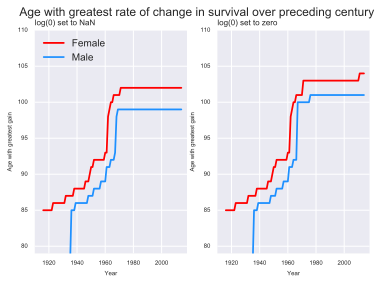

In [11]:
lt.ignorezero = False
x,y = lt.get_fig1d()
mlt.ignorezero = False
mx,my = mlt.get_fig1d()
ax = plt.subplot(121, xlabel='Year', ylabel='Age with greatest gain')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)
plt.plot(x,y,color=lt.colour,label='Female')
plt.plot(mx,my,color=mlt.colour,label='Male')
plt.axis((1910,2018,79,110))
plt.title('log(0) set to NaN', loc='left', fontsize=8)
plt.legend(loc=2)

lt.ignorezero = True
x,y = lt.get_fig1d()
mlt.ignorezero = True
mx,my = mlt.get_fig1d()
ax = plt.subplot(122, xlabel='Year', ylabel='Age with greatest gain')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)
plt.plot(x,y,color=lt.colour,label='Female')
plt.plot(mx,my,color=mlt.colour,label='Male')
plt.axis((1910,2018,79,110))
plt.title('log(0) set to zero', loc='left', fontsize=8)

plt.suptitle('Age with greatest rate of change in survival over preceding century',fontsize=12)
plt.show()

These are close, but not identical to what's in the paper. What I don't understand at the moment is that the Figure 1c is about a factor 2 out from what's in the paper (I had the same factor 2 when I calculated the trends a different way, so either I misunderstood what they did, I always do the same stupid thing, or they did something I missed, or some combination) and despite the shape of Figure 1d being about right, the exact transitions are not quite identical to those in the paper. Something is going on with the way the regressions were done that I can't quite put my finger on. Maybe I've got the wrong variable from the file. Heh.

There are also some features of how the dataset is put together that need some thought. From 2007 onwards, the lifetables from which the data are constructed max out at 104+. Prior to that point, 

So what can we take away from this at the moment. Well, first, the drop off in the rate of change of survivors/100k occurs above an age of 102, which is above the age at which we have a complete series of data. In that case, the drop off is going to depend on how we deal with the missing data. Second, we see a plateau in Figure 1d too, at an age of 102 for females and 99 for males. These are the highest ages for each sex for which we have complete data. The plateau, in this case, might only mean that we've maxed out that data, not that we've maxed out survival improvements in very old people in France.

The authors state that "_Together, these findings suggest, but do not prove, that human lifespan may have a natural limit. To further investigate this idea, we turned our attention from late-life mortality to maximum human lifespan itself and examined the ages at death of the world's oldest individuals._"

In the next notebook, I'll look at the data on maximum human lifespan.

